In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import glob
import os
import random
import cv2 as cv
import ast  # To safely parse strings containing lists/dictionaries
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_dir = '/content/drive/MyDrive/Colab Notebooks'

def get_data(npz_file):
  data_npz = np.load(npz_file, allow_pickle=True)
  data_list = data_npz["data"].tolist()
  return data_list

#full dataset now
epidural = get_data(file_dir + "/epidural.npz")
intraventricular = get_data(file_dir + "/intraventricular.npz")
multi = get_data(file_dir + "/multi.npz")
subdural = get_data(file_dir + "/subdural.npz")
subarachnoid = get_data(file_dir + "/subarachnoid.npz")
intraparenchymal = get_data(file_dir + "/intraparenchymal.npz")

Mounted at /content/drive


In [ ]:
ep_ex = epidural[0]

print(ep_ex.keys())

dict_keys(['Origin', 'Image Matrix', 'All Labels', 'Majority Label', 'Correct Label', 'Difficulty', 'Agreement', 'Total Qualified Reads', 'Class'])


In [ ]:
def display_image(img_matrix, img_name):
    plt.figure(figsize=(6, 6))
    if len(img_matrix.shape) == 2:
        plt.imshow(img_matrix, cmap="gray")  # Grayscale
    else:
        plt.imshow(img_matrix)
    plt.axis("off")
    plt.title(f"Image: {img_name}")
    plt.show()

    # Print shape of matrix (H, W, C)
    print(f"Image shape: {img_matrix.shape}")

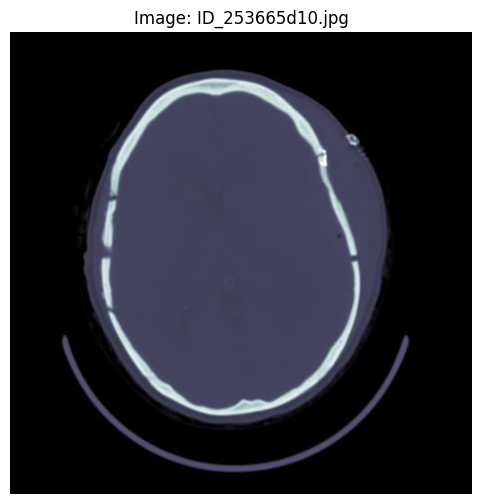

Image shape: (512, 512, 3)
[[{'x': 0.62809026, 'y': 0.24295628}, {'x': 0.6440478, 'y': 0.30550998}, {'x': 0.6223455, 'y': 0.36359555}, {'x': 0.640218, 'y': 0.41848963}, {'x': 0.70532495, 'y': 0.4695539}, {'x': 0.74298483, 'y': 0.5340225}, {'x': 0.6995802, 'y': 0.38657448}, {'x': 0.6606437, 'y': 0.2901907}], [{'x': 0.6514995, 'y': 0.28909296}, {'x': 0.62680125, 'y': 0.38187823}, {'x': 0.6595097, 'y': 0.42927215}, {'x': 0.69088316, 'y': 0.4479627}, {'x': 0.72759676, 'y': 0.5047019}, {'x': 0.71891904, 'y': 0.4346123}]]


In [ ]:
#need to convert from string due to csv conversion
image_matrix = epidural[0]['Image Matrix']  # Convert string to array
display_image(image_matrix, epidural[0]['Origin'])

#print(np.max(image_matrix), np.min(image_matrix))

print((epidural[0]['All Labels']))

In [ ]:
def create_binary_mask(image_shape, processed_labels):
    """
    Create a binary mask over an image using a given list of polygon points.

    :param image_shape: Tuple (height, width) of the image.
    :param processed_labels: List of polygons, each polygon being a list of dictionaries with 'x' and 'y' coordinates.
    :return: Binary mask as a NumPy array.
    """
    height, width, channels = image_shape

    # Create an empty mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Loop through each polygon in the processed_labels
    for poly in processed_labels:
        # Convert normalized points to pixel coordinates
        polygon_points = [
            [int(point["x"] * width), int(point["y"] * height)] for point in poly
        ]

        # Fill the polygon region with 1 (or 255 for visualization)
        if len(polygon_points) > 0:
            cv.fillPoly(mask, [np.array(polygon_points, dtype=np.int32)], 1)

    return mask

def overlay_mask(image, mask, alpha=0.5):
    """
    Overlay a binary mask onto an image.

    :param image: The input image (in BGR format).
    :param mask: Binary mask to overlay (should be the same size as the image).
    :param alpha: Transparency factor for the mask overlay (default is 0.5).
    :return: The image with the mask overlaid.
    """

    # Ensure image is in uint8 format
    if image.dtype != np.uint8:
        # If image values are in the range [0, 1], scale them up to 255
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)

    # Create a colored mask with the same shape as the image
    mask_colored = np.zeros_like(image)
    # Multiply mask by 255 to get values in the range [0, 255] and assign to green channel
    mask_colored[:, :, 1] = (mask * 255).astype(np.uint8)
    # Ensure mask_colored is in uint8 format
    mask_colored = mask_colored.astype(np.uint8)

    # Now blend the image and the mask using addWeighted
    overlay = cv.addWeighted(image, 1, mask_colored, alpha, 0)

    return overlay


In [ ]:
labels = epidural[0]["All Labels"]
print(len(labels), len(labels[0]), len(labels[0][0]))

for label in labels:
  for coord in label:
    print(f"x: {coord['x']}, y: {coord['y']}")

2 8 2
x: 0.62809026, y: 0.24295628
x: 0.6440478, y: 0.30550998
x: 0.6223455, y: 0.36359555
x: 0.640218, y: 0.41848963
x: 0.70532495, y: 0.4695539
x: 0.74298483, y: 0.5340225
x: 0.6995802, y: 0.38657448
x: 0.6606437, y: 0.2901907
x: 0.6514995, y: 0.28909296
x: 0.62680125, y: 0.38187823
x: 0.6595097, y: 0.42927215
x: 0.69088316, y: 0.4479627
x: 0.72759676, y: 0.5047019
x: 0.71891904, y: 0.4346123


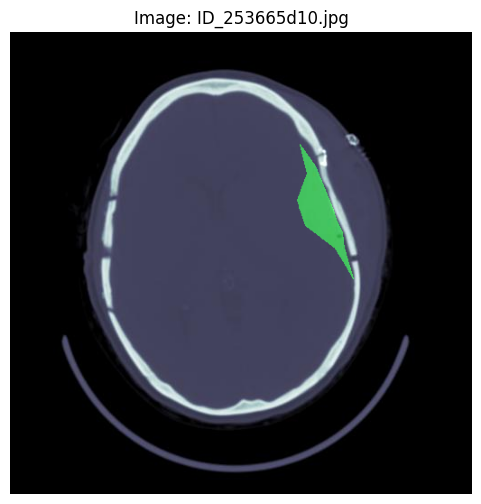

Image shape: (512, 512, 3)


In [ ]:
overlayed = overlay_mask(image_matrix, create_binary_mask(image_matrix.shape, labels))
display_image(overlayed, epidural[0]['Origin'])

In [ ]:
def getLabel(label):
  if label == "epidural":
    return 0
  elif label == "intraparenchymal":
    return 1
  elif label == "intraventricular":
    return 2
  elif label == "subarachnoid":
    return 3
  elif label == "subdural":
    return 4
  elif label == "multi":
    return 5

def getLabelString(label):
  if label == 0:
    return "epidural"
  elif label == 1:
    return "intraparenchymal"
  elif label == 2:
    return "intraventricular"
  elif label == 3:
    return "subarachnoid"
  elif label == 4:
    return "subdural"
  elif label == 5:
    return "multi"

In [ ]:
import numpy as np
import cv2 as cv

def appendData(npzList, X, y):
    for data in npzList:
        image = data["Image Matrix"]
        gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        resized_image = cv.resize(gray_image, (512, 512))
        X.append(resized_image)

        mask = create_binary_mask(image.shape, data["All Labels"])
        resized_mask = cv.resize(mask.astype(np.uint8), (512, 512), interpolation=cv.INTER_NEAREST)
        y.append(resized_mask)

    return X, y

X = []
y = []

X, y = appendData(epidural, X, y)
X, y = appendData(intraparenchymal, X, y)
X, y = appendData(intraventricular, X, y)
X, y = appendData(subarachnoid, X, y)
X, y = appendData(subdural, X, y)
X, y = appendData(multi, X, y)

X = np.array(X, dtype=np.float32)[..., np.newaxis] / 255.0
y = np.array(y, dtype=np.float32)[..., np.newaxis]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (600, 512, 512, 1)
y shape: (600, 512, 512, 1)


In [ ]:
##SEGMENTATION
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.applications import ResNet50  # substitute for ResNet18

def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return 1.0 - intersection / (union + 1e-7)

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    return 1.0 - (2. * intersection + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    iou = iou_loss(y_true, y_pred)
    return bce + iou

In [ ]:
def build_segmentation_model(input_shape=(512, 512, 1)):
    base_model = tf.keras.applications.ResNet50(
        input_shape=(512, 512, 3),  # we'll tile the grayscale image to 3 channels
        include_top=False,
        weights='imagenet'
    )

    # Freeze early layers if needed
    for layer in base_model.layers[:80]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Concatenate()([inputs, inputs, inputs])  # 1-channel → 3-channel

    x = base_model(x)

    # Decoder (upsampling path)
    x = layers.Conv2DTranspose(512, 3, strides=2, padding="same", activation='relu')(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation='relu')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation='relu')(x)

    # Final layer: single channel mask
    outputs = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(x)

    return models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model = build_segmentation_model()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combo_loss,
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name="pixel_accuracy"),
                  tf.keras.metrics.MeanIoU(num_classes=2, name="iou_score")
              ])

# Train
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=50,
                    validation_split=0.2)

Epoch 1/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 27:20 30s/step - iou_score: 0.4931 - loss: 1.6759 - pixel_accuracy: 0.6458

KeyboardInterrupt: 

In [ ]:
history.history["pixel_accuracy"]
history.history["val_pixel_accuracy"]

history.history["iou_score"]
history.history["val_iou_score"]

results = model.evaluate(X_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

NameError: name 'history' is not defined